<h2>Description:</h2>
A framework for using machine learning to predict the future value of a timeseries.

<h2>Get all the things.</h2>

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from keras import layers
from tqdm import tqdm
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D,GlobalAveragePooling1D
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


<h2>Define Some Parameters:</h2>

In [88]:
dataseries_length = 300
lookahead_fraction = 0.1 #fraction of dataset to look ahead.
nphases = 3 #number of independant sine wave in the dataset.
ntest = 20000 # number of tetset datapoints
ntrain = 4000# number of training datapoints

<h2>Generate A Dataset of Complex Timeseries</h2>

In [8]:
#genearte a complex time series
def generateTimeSeries(length,ncomps):
    xx = np.arange(length)
    y = 0;
    for j in range(0,ncomps):
        period = np.random.rand(1)
        phase  = np.random.randint(length)
        y =  y+np.sin((xx+phase)*period/6.28)/period
    return y

#for baslining, leys look at a som of random numbers (random walk)
def generateCumSum(length,p1,ncomps):
    xx = np.random.randn(length)
    return np.cumsum(xx)

#takes a time series and splits it at a fraction of its length, and returns a point at the and for predicting.
def generateXy(series,fraction):
    xlen = series.shape[0]*fraction
    xlen = int(round(xlen))
    X = series[0:xlen]
    y = series[-1]
    return (X,y)

#combine multiple timeseries X,y points into a training set, normalize arch one.
def makeDataset(n): 
    A = []
    y = []
    for j in tqdm(range(0,n)):
        # Xtemp,ytemp = generateXy(generateCumSum(200,1,4),.5)
       # Xtemp,ytemp = generateXy(generateTimeSeries(dataseries_length,nphases),1-lookahead_fraction)
        Xtemp,ytemp = generateXy(generateSyntheticStockSeries(dataseries_length),1-lookahead_fraction)
        Xtemp = Xtemp.reshape(-1,1)
        ytemp = ytemp.reshape(-1,1)
        xmin = np.min(Xtemp)
        xmax = np.max(Xtemp)
        Xtemp = (Xtemp-xmin)/(xmax-xmin)
        ytemp = (ytemp-xmin)/(xmax-xmin)
        A.append(Xtemp)
        y.append(ytemp)      
    A = np.array(A)
    y = np.array(y)
    A = A.reshape(A.shape[0],A.shape[1])
    y = y.reshape(n)
    return (A,y)       

<h2>Build the dataset</h2>
Build training and testing dataset, and show a couple representative plots

100%|██████████| 20000/20000 [1:33:06<00:00,  3.92it/s]  


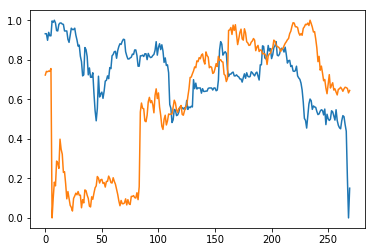

In [89]:
A,y = makeDataset(ntrain)
Aval,yval = makeDataset(ntest)
xx = range(0,A.shape[1])
_ = plt.plot(xx,A[0],xx,A[-1])

<h2>Define the 1st Model - Fully connected NN</h2>

In [104]:
y.shape

(4000,)

In [80]:
model = Sequential()
model.add(Dense(A.shape[1],input_shape=(A.shape[1],),activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(128,activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 270)               73170     
_________________________________________________________________
dropout_5 (Dropout)          (None, 270)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               34688     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
__________

Train on 20000 samples, validate on 4000 samples
Epoch 1/50
 - 1s - loss: 0.1215 - mean_absolute_error: 0.2165 - val_loss: 0.1427 - val_mean_absolute_error: 0.2645
Epoch 2/50
 - 1s - loss: 0.1211 - mean_absolute_error: 0.2149 - val_loss: 0.1423 - val_mean_absolute_error: 0.2633
Epoch 3/50
 - 1s - loss: 0.1196 - mean_absolute_error: 0.2142 - val_loss: 0.1157 - val_mean_absolute_error: 0.2197
Epoch 4/50
 - 1s - loss: 0.1198 - mean_absolute_error: 0.2135 - val_loss: 0.1315 - val_mean_absolute_error: 0.2457
Epoch 5/50
 - 1s - loss: 0.1193 - mean_absolute_error: 0.2132 - val_loss: 0.1220 - val_mean_absolute_error: 0.2309
Epoch 6/50
 - 1s - loss: 0.1191 - mean_absolute_error: 0.2137 - val_loss: 0.1202 - val_mean_absolute_error: 0.2279
Epoch 7/50
 - 1s - loss: 0.1189 - mean_absolute_error: 0.2122 - val_loss: 0.1220 - val_mean_absolute_error: 0.2312
Epoch 8/50
 - 1s - loss: 0.1184 - mean_absolute_error: 0.2126 - val_loss: 0.1257 - val_mean_absolute_error: 0.2372
Epoch 9/50
 - 1s - loss: 0.1184

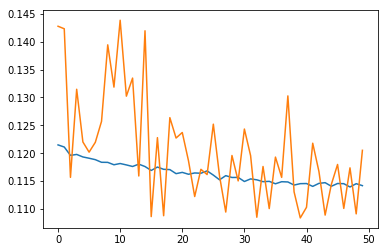

In [99]:
h = model.fit(Aval, yval, batch_size=128, epochs=50, verbose=2,validation_data=(A, y))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

In [154]:
yfit = model.predict(A)
#yfitc1 = covmodel1.predict(Aval.reshape(30000,170,1))
yfitc2 = covmodel2.predict(A.reshape(4000,270,1))
yfit = yfit.reshape(-1,)
yfit.shape

(4000,)

In [ ]:
#yavg = (yfit+yfitc1+yfitc2)/3
#plt.plot(yval,yfit,'bo')

lastp = A[:,269]
#yfitc = model.predict(Aval.reshape(60000,170,1)).reshape(-1)
delta = y-lastp
deltap = yfitc2-lastp
plt.plot(deltap,delta,'bo')
lastp.shape

(4000,)

In [110]:
print(np.corrcoef(y.T,yfit.T))
print(np.corrcoef(delta.T,deltap.T))

[[1.         0.68885494]
 [0.68885494 1.        ]]
[[1.         0.01536487]
 [0.01536487 1.        ]]


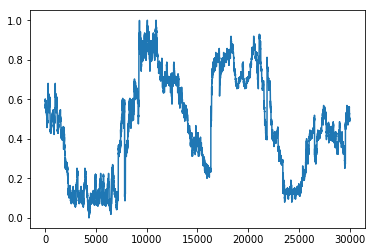

In [139]:
s = generateSyntheticStockSeries(30000)
plt.plot(s)

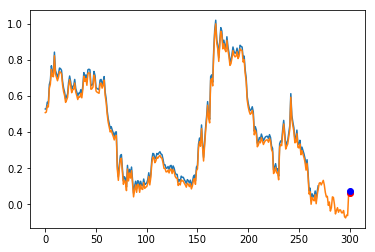

In [135]:
delta = 10
s = generateSyntheticStockSeries(300)
X1,y1 = generateXy(s,.9)
xmin = np.min(X1)
xmax = np.max(X1)
X1 = (X1-xmin)/(xmax-xmin)
y1 = (y1-xmin)/(xmax-xmin)
s = (s-xmin)/(xmax-xmin)
x = range(0,A.shape[1])
xx = range(0,300)
xxp = 300
#p = covmodel1.predict(X1.reshape(1,170,1))
p = model.predict(X1.reshape(-1,270))
#cp3 = covmodel3.predict(X1.reshape(1,370,1))
#cp2 = covmodel2.predict(X1.reshape(1,370,1))
#_= plt.plot(x,X1+.02,xx,s,xxp,y1,'ro',xxp,p,'bo',xxp,cp1,'go',xxp,cp2,'yo',xxp,cp3,'gx')
_ = plt.plot(x,X1+.02,xx,s,xxp,y1,'ro',xxp,p,'bo')
#print("p1 = {} p2 = {} p3 = {}".format(p1,p2,p3))

In [161]:
#yfit = model.predict(Aval).reshape(-1)
#lastp = Aval[:,169]
#delta = yval-lastp
#deltap = yfit-lastp
#plt.plot(deltap,delta,'bo')

lastp = Aval[:,269]
yfitc = model.predict(Aval.reshape(60000,170,1)).reshape(-1)
delta = yval-lastp
deltap = yfitc-lastp
#print("shapes = {},{},{}".format(yfitc.shape,yval.shape,lastp.shape))

In [162]:
n_correct = []
avgdelta = []
for p in np.arange(-100,100):
    deltagt = delta[deltap>p/100]
    sumd = np.sum(deltagt) 
    npoints = deltagt.shape[0] 
    avgdelta.append(sumd/npoints)
    nc = sum(deltagt>0)/sum(deltagt>-2)
    n_correct.append(nc)

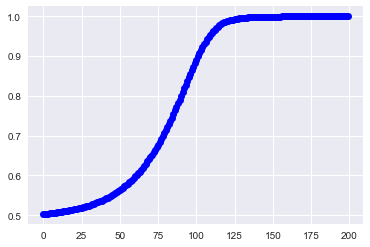

In [163]:
plt.plot(n_correct,'bo')

In [164]:
np.corrcoef(delta.T,deltap.T)

array([[ 1.        ,  0.92722763],
       [ 0.92722763,  1.        ]])

In [144]:
covmodel1 = Sequential()
covmodel1.add( Convolution1D( nb_filter=32, filter_length=10, input_shape=(A.shape[1], 1)))
covmodel1.add(Activation('relu'))
covmodel1.add(Flatten())
covmodel1.add(Dropout(0.4))
covmodel1.add(Dense(128, activation='relu'))
covmodel1.add(Dense(64, activation='relu'))
covmodel1.add(Dense(1))
covmodel1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
covmodel1.summary()

C:\Users\jwwilson\AppData\Local\Continuum\Anaconda2\envs\ztdl\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=32, input_shape=(170, 1), kernel_size=10)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 161, 32)           352       
_________________________________________________________________
activation_3 (Activation)    (None, 161, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5152)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5152)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               659584    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total para

In [151]:
covmodel2 = Sequential()
covmodel2.add( Convolution1D( nb_filter=100, filter_length=20, input_shape=(A.shape[1], 1)))
covmodel2.add(Activation('relu'))
#model_m.add(MaxPooling1D(3))
covmodel2.add(Flatten())
covmodel2.add(Dropout(0.4))
covmodel2.add(Dense(128, activation='relu'))
covmodel2.add(Dense(64, activation='relu'))
covmodel2.add(Dense(1))
covmodel2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
covmodel2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 251, 100)          2100      
_________________________________________________________________
activation_5 (Activation)    (None, 251, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25100)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 25100)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               3212928   
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total para

/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(270, 1), kernel_size=20, filters=100)`
  


In [148]:
yval.shape

(20000,)

Train on 20000 samples, validate on 4000 samples
Epoch 1/20
20000/20000 [==============================] - 30s 1ms/step - loss: 1.3761 - mean_absolute_error: 0.3838 - val_loss: 0.1315 - val_mean_absolute_error: 0.2402
Epoch 2/20
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1354 - mean_absolute_error: 0.2381 - val_loss: 0.1329 - val_mean_absolute_error: 0.2462
Epoch 3/20
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1265 - mean_absolute_error: 0.2237 - val_loss: 0.1827 - val_mean_absolute_error: 0.3182
Epoch 4/20
20000/20000 [==============================] - 29s 1ms/step - loss: 0.1227 - mean_absolute_error: 0.2181 - val_loss: 0.1162 - val_mean_absolute_error: 0.2155
Epoch 5/20
20000/20000 [==============================] - 30s 1ms/step - loss: 0.1193 - mean_absolute_error: 0.2131 - val_loss: 0.1258 - val_mean_absolute_error: 0.2347
Epoch 6/20
20000/20000 [==============================] - 28s 1ms/step - loss: 0.1181 - mean_absolute_erro

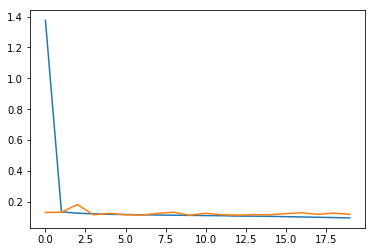

In [152]:
hc = covmodel2.fit(Aval.reshape(20000,270,1), yval.reshape(-1,1), batch_size=128, epochs=20, verbose=1,validation_data=(A.reshape(4000,270,1), y.reshape(-1,1)))
plt.plot(hc.history['loss'])
plt.plot(hc.history['val_loss'])

Train on 80000 samples, validate on 30000 samples
Epoch 1/1
80000/80000 [==============================] - 1229s - loss: 0.2100 - mean_absolute_error: 0.3611 - val_loss: 0.1661 - val_mean_absolute_error: 0.3396


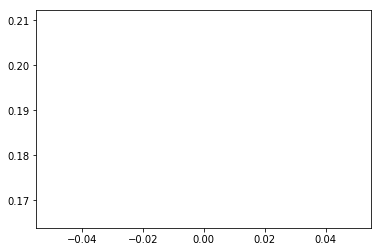

In [350]:
hc = covmodel2.fit(A.reshape(80000,370,1), y, batch_size=128, epochs=1, verbose=1,validation_data=(Aval.reshape(30000,370,1), yval))
plt.plot(hc.history['loss'])
plt.plot(hc.history['val_loss'])

In [349]:
model_m = Sequential()
model_m.add( Convolution1D( nb_filter=100, filter_length=10, input_shape=(A.shape[1], 1)))
model_m.add(Convolution1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Convolution1D(160, 10, activation='relu'))
model_m.add(Convolution1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))

model_m.add(Dense(128, activation='relu'))
model_m.add(Dense(64, activation='relu'))
model_m.add(Dense(1))
model_m.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model_m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 361, 100)          1100      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 352, 100)          100100    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 117, 100)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 108, 160)          160160    
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 99, 160)           256160    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 160)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 160)               0         
__________

/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=10, filters=100, input_shape=(370, 1))`
  


In [146]:
yfitc = covmodel1.predict(Aval.reshape(60000,170,1))

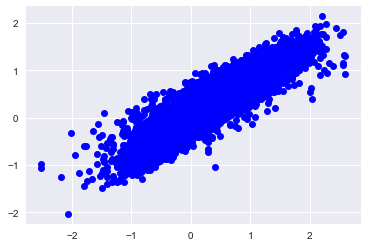

In [147]:
plt.plot(yval,yfitc,'bo')

In [148]:
np.corrcoef(yval.T,yfitc.T)

array([[ 1.        ,  0.94246068],
       [ 0.94246068,  1.        ]])

In [1365]:
maxvals = np.max(A,axis = 1).reshape(-1,1)
minvals = np.min(A,axis=1).reshape(-1,1)
As = (A-minvals)/(maxvals-minvals)
y = (y-minvals)/(maxvals-minvals)

maxvals = np.max(Aval,axis = 1).reshape(-1,1)
minvals = np.min(Aval,axis=1).reshape(-1,1)
Avals = (Aval-minvals)/(maxvals-minvals)
yval = (yval-minvals)/(maxvals-minvals)

In [1366]:
y[1]

array([-0.47448836])

In [1396]:
list1 = []
a = np.random.rand(10,1)
list1.append(a)

In [1399]:
list1.append(a)

In [1400]:
np.array(list1).shape

(4, 10, 1)

In [99]:
for p in np.arange(-1,1,.1):
    print(p)

-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.4
-0.3
-0.2
-0.1
-2.22044604925e-16
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [44]:
#imports
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

#params
series_length = 200
n_mix = 3
path = '/Users/johnwilson/Documents/EquityData/'

def getCsvFiles(path):
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    csvs = [f for f in onlyfiles if f.split('.')[1] == 'csv']
    return csvs

def generateSyntheticStockSeries(seriesLength):
    csvlist = np.array(getCsvFiles(path))
    n_files = len(csvlist)
    np.random.shuffle(csvlist)
    nstart = np.random.randint(78000)
    indata = pd.read_csv(path+csvlist[0],header=None)
    indata = indata[4].values
    dataseries = np.random.randn(1)*indata[nstart:(nstart+seriesLength)]
    for j in range (1,n_mix):
        indata = pd.read_csv(path+csvlist[j],header=None)
        indata = indata[4].values
        dataseries += np.random.randn(1)*indata[(nstart+seriesLength)]
    #normalize on first half
    a = np.max(dataseries[0:np.round(seriesLength*.9).astype(int)])
    b = np.min(dataseries[0:np.round(seriesLength*.9).astype(int)])
    dataseries = (dataseries-b)/(a-b)
    #dataseries = dataseries[1500:-1]        
    return dataseries

In [43]:
type(np.round(102.1).astype(int))

numpy.int64